http://mapfrappe.com/?show=51352

In [1]:
import time
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import osmnx as ox
from scipy import stats
from shapely.geometry import Point, Polygon, LineString, MultiLineString

from planar import *

ox.config(use_cache=True, log_console=True)
%matplotlib inline

## Configure the script

In [2]:
df_places = pd.read_csv('data/places.csv')

distances = [805] #804.67 meters in each direction makes for 1 square mile, 500 meters is 1 sq km

network_types = ['drive', 'walk']

In [3]:
#df_places = df_places.loc[37:37]
df_places

,country,city,lat,lng
0,Argentina,Buenos Aires,-34.608657,-58.375547
1,Australia,Sydney,-33.863616,151.208977
2,Brazil,Sao Paulo,-23.549155,-46.633600
3,Canada,Toronto,43.649903,-79.380838
4,Canada,Vancouver,49.281651,-123.121363
5,Chile,Santiago,-33.439754,-70.654296
6,China,Beijing,39.908427,116.465505
7,China,Shanghai,31.236286,121.503787
8,China,Hong Kong,22.282321,114.156843
9,Denmark,Copenhagen,55.679443,12.578284


## Execute the script

In [4]:
# convert df to dict for execution
places = {}
for label, row in df_places.iterrows():
    key = '{}_{}'.format(row['country'], row['city'])
    value = (row['lat'], row['lng'])
    places[key] = value
    
places = df_places

In [5]:
results = []
for label, row in df_places.iterrows():
    
    coords = (row['lat'], row['lng'])
    point = Point(row['lng'], row['lat'])
    
    for network_type in network_types:
        
        for distance in distances:

            print(row['country'], row['city'], network_type, distance, end=' ')
            try:

                start_time = time.time()
                G = get_graph(coords, distance, network_type)

                # get a special buffered graph for planar analysis
                buffer = 500
                G_buff = get_graph(coords, distance + buffer, network_type)

                # get a bounding box to trim things square
                north, south, east, west = ox.bbox_from_point(coords, distance)
                bbox = Polygon([(west, north), (west, south), (east, south), (east, north)])

                # how many planar line intersections are there?
                planar_intersections = calculate_planar_intersections(G_buff, bbox)
                count_planar_intersections = len(planar_intersections)

                # how many nonplanar graph edge intersections are there?
                nonplanar_intersections = calculate_nonplanar_intersections(G, bbox)
                count_nonplanar_intersections = len(nonplanar_intersections)

                # how many cleaned, clustered intersections are there?
                cleaned_intersections = calculate_cleaned_intersections(nonplanar_intersections, G.graph['crs'])
                count_cleaned_intersections = len(cleaned_intersections)
                
                # how does planarity affect average edge length?
                mean_edge_length, mean_planar_segment_length, edge_length_ratio = calculate_edge_length_ratios(G, planar_intersections)

                if count_nonplanar_intersections > 0:
                    # planar line intersections overcounts nonplanar graph edge intersections by xx%
                    # ie, planar graph shows xx% more intersections than nonplanar graph with bridges/tunnels
                    planar_nonplanar_overcount = count_planar_intersections / count_nonplanar_intersections
                else:
                    planar_nonplanar_overcount = None #avoid divide by zero errors

                if count_cleaned_intersections > 0:
                    # edge intersections overcounts street intersections by xx%
                    nonplanar_cleaned_overcount = count_nonplanar_intersections / count_cleaned_intersections

                    # line intersections overcounts street intersections by xx%
                    planar_cleaned_overcount = count_planar_intersections / count_cleaned_intersections
                else:
                    planar_cleaned_overcount = None #avoid divide by zero errors
                    nonplanar_cleaned_overcount = None

                
                runtime = round(time.time() - start_time, 2)
                print(runtime)
                
                # assemble the results
                result = {'country' : row['country'], 
                          'city' : row['city'],
                          'geometry' : point,
                          'distance' : distance,
                          'network_type' : network_type,
                          'nodes' : len(G.nodes()),
                          'count_planar_intersections' : count_planar_intersections,
                          'count_nonplanar_intersections' : count_nonplanar_intersections,
                          'count_cleaned_intersections' : count_cleaned_intersections,
                          'overcount_planar_nonplanar' : planar_nonplanar_overcount,
                          'overcount_nonplanar_cleaned' : nonplanar_cleaned_overcount,
                          'overcount_planar_cleaned' : planar_cleaned_overcount,
                          'mean_edge_length' : mean_edge_length,
                          'mean_planar_segment_length' : mean_planar_segment_length,
                          'edge_length_ratio' : edge_length_ratio,
                          'runtime' : runtime}
                results.append(result)

            except Exception as e:
                print(e)

Argentina Buenos Aires drive 805 8.38
Argentina Buenos Aires walk 805 66.86
Australia Sydney drive 805 5.95
Australia Sydney walk 805 79.46
Brazil Sao Paulo drive 805 14.47
Brazil Sao Paulo walk 805 45.92
Canada Toronto drive 805 8.38
Canada Toronto walk 805 1029.15
Canada Vancouver drive 805 6.53
Canada Vancouver walk 805 65.1
Chile Santiago drive 805 8.68
Chile Santiago walk 805 29.44
China Beijing drive 805 2.78
China Beijing walk 805 6.95
China Shanghai drive 805 5.21
China Shanghai walk 805 16.63
China Hong Kong drive 805 13.8
China Hong Kong walk 805 133.59
Denmark Copenhagen drive 805 9.62
Denmark Copenhagen walk 805 92.38
Egypt Cairo drive 805 12.51
Egypt Cairo walk 805 21.74
France Lyon drive 805 21.96
France Lyon walk 805 107.23
France Paris drive 805 14.45
France Paris walk 805 97.99
Germany Berlin drive 805 6.08
Germany Berlin walk 805 193.02
India Delhi drive 805 2.02
India Delhi walk 805 11.92
Indonesia Jakarta drive 805 11.99
Indonesia Jakarta walk 805 25.95
Iran Tehran 

In [6]:
gdf = gpd.GeoDataFrame(results, geometry='geometry').round(3)
gdf.crs = {'init': 'epsg:4326'}
print('finished in {:.2f} minutes'.format(gdf['runtime'].sum() / 60))

finished in 117.26 minutes


In [7]:
# display the results
gdf

,city,count_cleaned_intersections,count_nonplanar_intersections,count_planar_intersections,country,distance,edge_length_ratio,geometry,mean_edge_length,mean_planar_segment_length,network_type,nodes,overcount_nonplanar_cleaned,overcount_planar_cleaned,overcount_planar_nonplanar,runtime
0,Buenos Aires,211,222,222,Argentina,805,1.000,POINT (-58.375547 -34.608657),111.152,111.151,drive,272,1.052,1.052,1.000,8.38
1,Buenos Aires,291,652,689,Argentina,805,0.947,POINT (-58.375547 -34.608657),55.278,52.375,walk,871,2.241,2.368,1.057,66.86
2,Sydney,151,177,239,Australia,805,0.749,POINT (151.208977 -33.863616),150.771,112.902,drive,223,1.172,1.583,1.350,5.95
3,Sydney,499,808,889,Australia,805,0.901,POINT (151.208977 -33.863616),53.459,48.141,walk,1018,1.619,1.782,1.100,79.46
4,Sao Paulo,288,330,417,Brazil,805,0.790,POINT (-46.6336 -23.549155),111.740,88.282,drive,415,1.146,1.448,1.264,14.47
5,Sao Paulo,418,587,689,Brazil,805,0.831,POINT (-46.6336 -23.549155),76.628,63.694,walk,721,1.404,1.648,1.174,45.92
6,Toronto,203,214,230,Canada,805,0.958,POINT (-79.380838 43.649903),115.019,110.150,drive,271,1.054,1.133,1.075,8.38
7,Toronto,595,2834,3302,Canada,805,0.848,POINT (-79.380838 43.649903),33.584,28.476,walk,3356,4.763,5.550,1.165,1029.15
8,Vancouver,171,182,196,Canada,805,0.948,POINT (-123.121363 49.281651),133.992,127.027,drive,231,1.064,1.146,1.077,6.53
9,Vancouver,450,692,745,Canada,805,0.926,POINT (-123.121363 49.281651),67.541,62.550,walk,870,1.538,1.656,1.077,65.10


In [8]:
gdf[['city', 'overcount_planar_nonplanar']].sort_values(by='overcount_planar_nonplanar').head(10)

,city,overcount_planar_nonplanar
0,Buenos Aires,1.000
62,Barcelona,1.000
59,Mogadishu,1.000
58,Mogadishu,1.000
38,Milan,1.000
36,Florence,1.000
34,Bologna,1.000
28,Delhi,1.000
99,Caracas,1.000
61,Johannesburg,1.003


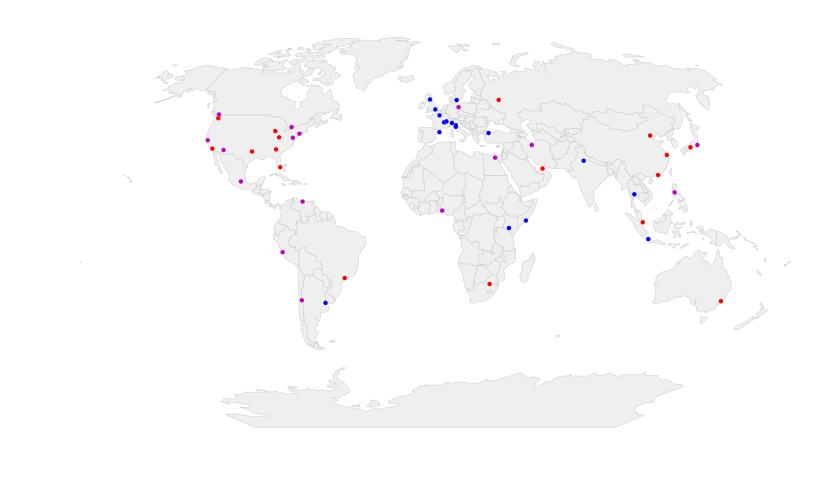

In [146]:
def get_color(value, breaks):
    
    if value <= breaks[0]:
        return 'b'
    elif value <= breaks[1]:
        return 'm'
    else:
        return 'r'
    
drive = gdf[gdf['network_type']=='drive']
breaks = [drive['overcount_planar_nonplanar'].quantile(q=x) for x in (0.33, 0.67)]
colors = drive['overcount_planar_nonplanar'].apply(get_color, breaks=breaks)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
crs_proj = '+proj=kav7'
world_proj = world.to_crs(crs_proj)
xmin, ymin, xmax, ymax = world_proj.unary_union.bounds
aspect_ratio = (xmax - xmin) / (ymax - ymin)
points_proj = drive.to_crs(crs_proj)

width = 14
fig, ax = plt.subplots(figsize=(width, width/aspect_ratio), facecolor='w')
ax = world_proj.plot(ax=ax, facecolor='#efefef', edgecolor='#cccccc', linewidth=0.5)
ax = points_proj.plot(ax=ax, marker='o', markersize=20, c=colors, edgecolor='#efefef', linewidth=0.1)
ax.axis('off')
fig.savefig('data/world_map.png', dpi=300)
plt.show()

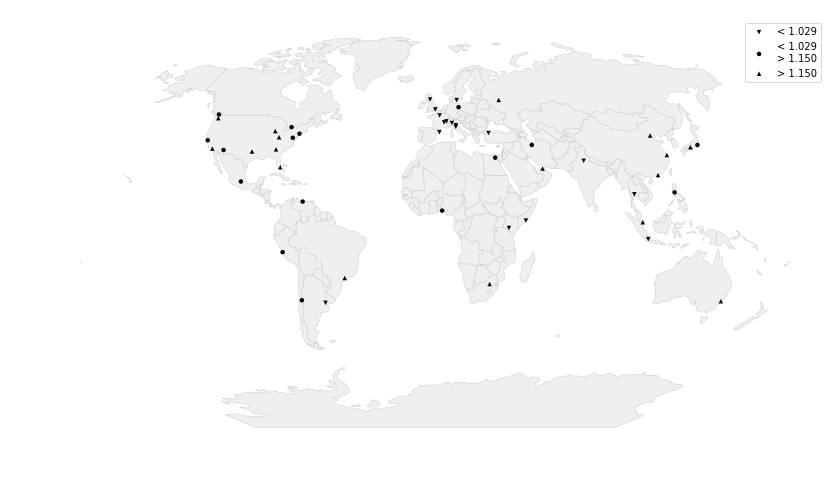

In [170]:
def get_marker(value, breaks):
    
    if value <= breaks[0]:
        return 1
    elif value <= breaks[1]:
        return 2
    else:
        return 3
    
drive = gdf[gdf['network_type']=='drive'].copy()
breaks = [drive['overcount_planar_nonplanar'].quantile(q=x) for x in (0.33, 0.67)]
drive['group'] = drive['overcount_planar_nonplanar'].apply(get_marker, breaks=breaks)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
crs_proj = '+proj=kav7'
world_proj = world.to_crs(crs_proj)
xmin, ymin, xmax, ymax = world_proj.unary_union.bounds
aspect_ratio = (xmax - xmin) / (ymax - ymin)
points_proj = drive.to_crs(crs_proj)

width = 14
fig, ax = plt.subplots(figsize=(width, width/aspect_ratio), facecolor='w')
ax = world_proj.plot(ax=ax, facecolor='#efefef', edgecolor='#cccccc', linewidth=0.5)

groups = []
points_proj[points_proj['group']==1].plot(ax=ax, marker='v', markersize=20, c='k', edgecolor='none', label='< {:.3f}'.format(breaks[0]))
points_proj[points_proj['group']==2].plot(ax=ax, marker='o', markersize=20, c='k', edgecolor='none', label='< {:.3f}\n> {:.3f}'.format(breaks[0], breaks[1]))
points_proj[points_proj['group']==3].plot(ax=ax, marker='^', markersize=20, c='k', edgecolor='none', label='> {:.3f}'.format(breaks[1]))
    
plt.legend()

ax.axis('off')
fig.savefig('data/world_map_bw.png', dpi=300)
plt.show()

r^2 = 0.968


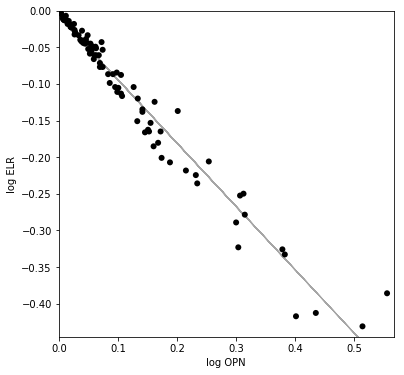

In [132]:
x = np.log(gdf['overcount_planar_nonplanar'].copy())
y = np.log(gdf['edge_length_ratio'].copy())
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print('r^2 = {:.3f}'.format(r_value ** 2))

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(x=x, y=y, c='k', edgecolor='none', marker='o')

# set x and y limits
x_min = x.min() * 0.98
x_max = x.max() * 1.02
y_min = y.min() * 0.98
y_max = y.max() * 1.02
ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

# create a line of best fit
x_line = x.copy()
x_line.loc[len(x_line)] = x_min
x_line.loc[len(x_line)] = x_max
Y_est = x_line * slope + intercept
ax.plot(x_line, Y_est, c='k', alpha=0.35, linewidth=1, zorder=-1)

ax.set_xlabel('log OPN')
ax.set_ylabel('log ELR')
fig.savefig('data/regression.png', dpi=300)
plt.show()

drive r^2 = 0.981
walk r^2 = 0.994


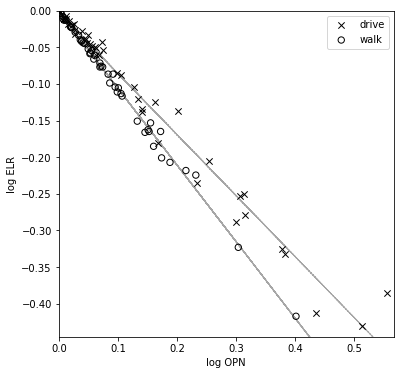

In [131]:
walk = gdf[gdf['network_type']=='walk']
drive = gdf[gdf['network_type']=='drive']

def transform(data):
    return np.log(data)

x = transform(gdf['overcount_planar_nonplanar'].copy())
y = transform(gdf['edge_length_ratio'].copy())
drive_x = transform(drive['overcount_planar_nonplanar'].copy())
drive_y = transform(drive['edge_length_ratio'].copy())
walk_x = transform(walk['overcount_planar_nonplanar'].copy())
walk_y = transform(walk['edge_length_ratio'].copy())

drive_slope, drive_intercept, drive_r_value, drive_p_value, drive_std_err = stats.linregress(drive_x, drive_y)
print('drive r^2 = {:.3f}'.format(drive_r_value ** 2))

walk_slope, walk_intercept, walk_r_value, walk_p_value, walk_std_err = stats.linregress(walk_x, walk_y)
print('walk r^2 = {:.3f}'.format(walk_r_value ** 2))

fig, ax = plt.subplots(figsize=(6,6))
drive_scatter = ax.scatter(x=drive_x, y=drive_y, c='k', edgecolor='none', s=40, linewidth=1, marker='x')
walk_scatter = ax.scatter(x=walk_x, y=walk_y, c='none', edgecolor='k', s=40, linewidth=1, marker='o')

# set x and y limits
x_min = x.min() * 0.98
x_max = x.max() * 1.02
y_min = y.min() * 0.98
y_max = y.max() * 1.02
ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

# create a line of best fit
x_line = x.copy()
x_line.loc[len(x_line)] = x_min
x_line.loc[len(x_line)] = x_max

drive_Y_est = x_line * drive_slope + drive_intercept
drive_line = ax.plot(x_line, drive_Y_est, c='k', alpha=0.35, linestyle=':', linewidth=1, zorder=-1)

walk_Y_est = x_line * walk_slope + walk_intercept
walk_line = ax.plot(x_line, walk_Y_est, c='k', alpha=0.35, linestyle='--', linewidth=1, zorder=-1)

ax.set_xlabel('log OPN')
ax.set_ylabel('log ELR')
plt.legend([drive_scatter, walk_scatter], ['drive', 'walk'])

fig.savefig('data/regression_split.png', dpi=300)
plt.show()

## Visualize one result

(10.494903, -66.850865)


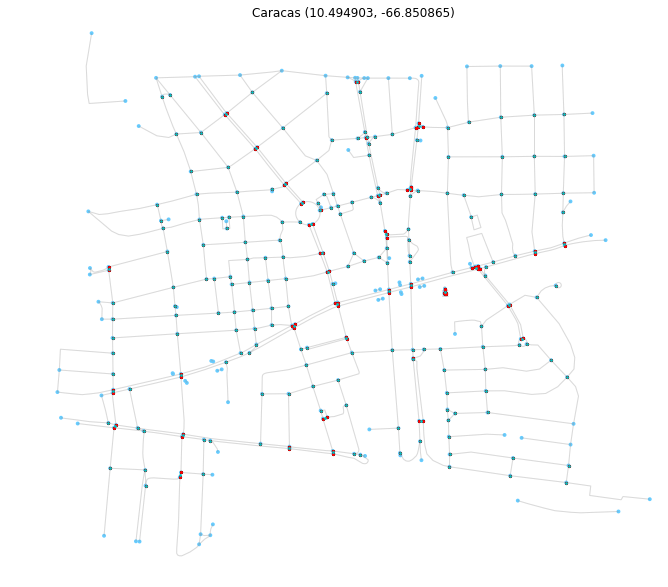

In [13]:
fig, ax = ox.plot_graph(G, fig_height=10, edge_alpha=0.2, node_alpha=None, close=True, show=False)

# show the true intersections in black
xs = nonplanar_intersections.map(lambda pt: pt.x)
ys = nonplanar_intersections.map(lambda pt: pt.y)
ax.scatter(xs, ys, c='k', s=5, zorder=2)

# plot the line split points in red to show false intersections
xs = planar_intersections.map(lambda pt: pt.x)
ys = planar_intersections.map(lambda pt: pt.y)
ax.scatter(xs, ys, c='r', s=4, zorder=3)

# plot consolidated intersections in cyan
xs = cleaned_intersections.map(lambda pt: pt.x)
ys = cleaned_intersections.map(lambda pt: pt.y)
ax.scatter(xs, ys, c='c', s=3, zorder=4)

print(coords)
ax.set_title('{} {}'.format(row['city'], coords))
fig.canvas.draw()
fig

## Save results to disk

In [14]:
ox.save_graph_shapefile(G, filename='graph', folder='data')

In [15]:
planar_intersections.to_file('data/graph/planar')
nonplanar_intersections.to_file('data/graph/nonplanar')
cleaned_intersections.to_file('data/graph/cleaned')

In [16]:
north, south, east, west = ox.bbox_from_point(coords, distance)
polygon = Polygon([(west, north), (west, south), (east, south), (east, north)])
gpd.GeoSeries([polygon]).to_file('data/graph/bbox')

In [17]:
gdf.to_csv('data/results.csv', index=True, encoding='utf-8')

In [18]:
gdf2 = gdf.set_index(['country', 'city', 'distance', 'network_type'])
gdf2.iloc[gdf2.index.get_level_values('network_type') == 'drive'].to_csv('data/results_drive.csv')
gdf2.iloc[gdf2.index.get_level_values('network_type') == 'walk'].to_csv('data/results_walk.csv')

## Make latex table

In [19]:
cols = ['country', 'city', 'network_type', 'overcount_planar_nonplanar', 
        'overcount_nonplanar_cleaned', 'overcount_planar_cleaned', 'edge_length_ratio']
table = gdf[cols].reindex(cols, axis=1).set_index(['country', 'city', 'network_type']).unstack(level=2)
table = table.swaplevel(i=0, j=1, axis=1)
table.columns = ['_'.join(col).strip() for col in table.columns]
table = table.reindex(sorted(table.columns), axis=1)
table

drive_edge_length_ratio  \
country      city                                     
Argentina    Buenos Aires                     1.000   
Australia    Sydney                           0.749   
Brazil       Sao Paulo                        0.790   
Canada       Toronto                          0.958   
             Vancouver                        0.948   
Chile        Santiago                         0.887   
China        Beijing                          0.872   
             Hong Kong                        0.835   
             Shanghai                         0.717   
Denmark      Copenhagen                       0.988   
Egypt        Cairo                            0.916   
France       Lyon                             0.989   
             Paris                            0.993   
Germany      Berlin                           0.950   
India        Delhi                            1.000   
Indonesia    Jakarta                          0.986   
Iran         Tehran                           0.973   
Italy        Bologna                          1.000   
             Florence                         1.000   
             Milan                            1.000   
Japan        Osaka                            0.871   
             Tokyo                            0.919   
Kenya        Nairobi                          0.974   
Mexico       Mexico City                      0.952   
Nigeria      Lagos                            0.967   
Peru         Lima                             0.941   
Philippines  Manila                           0.953   
Russia       Moscow                           0.680   
Singapore    Singapore                        0.874   
Somalia      Mogadishu                        1.000   
South Africa Johannesburg                     0.883   
Spain        Barcelona                        1.000   
Switzerland  Geneva                           0.982   
Thailand     Bangkok                          0.988   
Turkey       Istanbul                         0.982   
UAE          Dubai                            0.722   
UK           Edinburgh                        0.968   
             London                           0.981   
USA          Atlanta                          0.777   
             Chicago                          0.814   
             Cincinnati                       0.757   
             Dallas                           0.650   
             Los Angeles                      0.635   
             Miami                            0.662   
             New York                         0.901   
             Phoenix                          0.962   
             San Francisco                    0.941   
             Seattle                          0.779   
             Washington DC                    0.956   
Venezuela    Caracas                          0.957   

                            drive_overcount_nonplanar_cleaned  \
country      city                                               
Argentina    Buenos Aires                               1.052   
Australia    Sydney                                     1.172   
Brazil       Sao Paulo                                  1.146   
Canada       Toronto                                    1.054   
             Vancouver                                  1.064   
Chile        Santiago                                   1.074   
China        Beijing                                    1.754   
             Hong Kong                                  1.317   
             Shanghai                                   1.615   
Denmark      Copenhagen                                 1.175   
Egypt        Cairo                                      1.110   
France       Lyon                                       1.225   
             Paris                                      1.163   
Germany      Berlin                                     1.267   
India        Delhi                                      1.462   
Indonesia    Jakarta                                    1.218 

In [20]:
print(table.to_latex())

\begin{tabular}{llrrrrrrrr}
\toprule
          &         &  drive\_edge\_length\_ratio &  drive\_overcount\_nonplanar\_cleaned &  drive\_overcount\_planar\_cleaned &  drive\_overcount\_planar\_nonplanar &  walk\_edge\_length\_ratio &  walk\_overcount\_nonplanar\_cleaned &  walk\_overcount\_planar\_cleaned &  walk\_overcount\_planar\_nonplanar \\
country & city &                          &                                    &                                 &                                   &                         &                                   &                                &                                  \\
\midrule
Argentina & Buenos Aires &                    1.000 &                              1.052 &                           1.052 &                             1.000 &                   0.947 &                             2.241 &                          2.368 &                            1.057 \\
Australia & Sydney &                    0.749 &                      